<a href="https://colab.research.google.com/github/prosvirinKir/raai_project/blob/main/topic_classifier_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка данных

In [1]:
import torch
import itertools
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/blogtext.csv')

In [4]:
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [5]:
data['text'][456]

"              Frustration  I'm so frustrated! At the lack of productivity. At the hunger pangs caused by waiting...waiting...waiting...  I'm meant BE at Soony and Michy's for dinner right now, yet am stuck waiting for my ride to come, who's in turn, stuck at a meeting which should have been settled eons ago. The complications of starting a new business. Sheesh...  Ah wells. Yuli is heading down now to hand me some forms for data entry. Yippee. Am finally  doing  something...           "

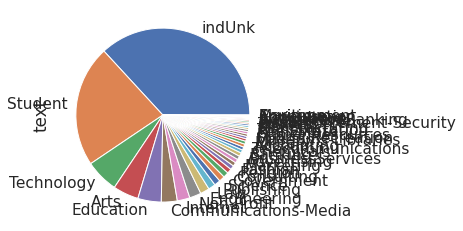

In [6]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie()

In [7]:
NUM_CLASSES = 5

data = data[data['topic'] != 'indUnk']
classes = data.groupby('topic', as_index=False).count()[['text', 'topic']].sort_values(['text'], ascending=False)['topic'].values[:NUM_CLASSES]

data = data[data['topic'].isin(classes)].reset_index(drop=True)

In [8]:
frequencies = data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].values / data.shape[0]
frequencies

array([0.55324969, 0.15117909, 0.11664749, 0.10652455, 0.07239917])

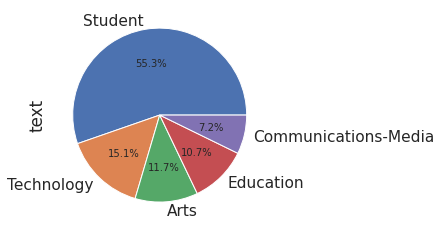

In [9]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [10]:
# for balanced data

# one_class_size = data[data['topic'] == classes[-1]].shape[0]

# prepr_data = pd.concat([data[data['topic'] == x][:one_class_size] for x in classes], axis=0)

# old_data = data
# data = prepr_data.reset_index(drop=True)

In [11]:
CUT = data.shape[0] #100000

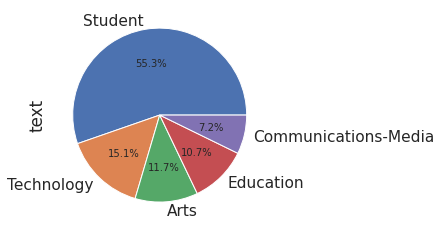

In [12]:
data.loc[:CUT, :].groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [13]:
label2idx = {label: i for i, label in enumerate(data['topic'].unique())}
idx2label = {i: label for i, label in enumerate(data['topic'].unique())}

In [14]:
for i in idx2label.keys():
  if label2idx[idx2label[i]] != i:
    print('aaa')

In [15]:
from sklearn.model_selection import train_test_split

train_indexes, test_indexes = train_test_split(data.index[:CUT], test_size=0.2, stratify=data['topic'][:CUT], shuffle=True)

In [16]:
 class Dataset:

    def __init__(self, data, labels, vocab=None):
        self.vocab = vocab
        self.data = data
        self.tokenised = None
        self.labels = [label2idx[label] for label in labels]

    def __getitem__(self, index):
        answer = {"input": self.tokenised[index]}
        if self.labels is not None:
            answer["label"] = self.labels[index]
        return answer

    def __len__(self):
        return len(self.data)
    
    def cut_to_fixed_size(self, max_size=512):
        self.tokenised = [text[:max_size] for text in tqdm(self.tokenised)]

    def drop_too_short(self, min_size=1):
      self.labels = [label for idx, label in tqdm(enumerate(self.labels)) if len(self.tokenised[idx]) > min_size]
      self.data = [text for idx, text in tqdm(enumerate(self.data)) if len(self.tokenised[idx]) > min_size]
      self.tokenised = [text for text in tqdm(self.tokenised) if len(text) > min_size]


In [17]:
train_dataset = Dataset(list(data['text'].values[train_indexes]), list(data['topic'].values[train_indexes]))
test_dataset = Dataset(list(data['text'].values[test_indexes]), list(data['topic'].values[test_indexes]))

In [18]:
import nltk

nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords as nltk_stopwords

nltk_stopwords = nltk_stopwords.words("english")

def is_word(word):
    word = word.lower()
    return all(x.isalpha() or x.isdigit() or x == "-" for x in word) and any(x.isalpha() or x.isdigit() for x in word)

def process_text(text, to_lower=True, only_alpha=True, remove_stopwords=False):
    words = wordpunct_tokenize(text) if isinstance(text, str) else text
    if to_lower:
        words = [word.lower() for word in words]
    if only_alpha:
        words = [word for word in words if is_word(word)]
    if remove_stopwords:
        words = [word for word in words if word not in nltk_stopwords]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
train_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(train_dataset.data)]
test_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(test_dataset.data)]

In [44]:
df = pd.DataFrame({'topic': [idx2label[x] for x in train_dataset.labels], 'data': train_dataset.tokenised, 'len': [len(x) for x in train_dataset.tokenised]})

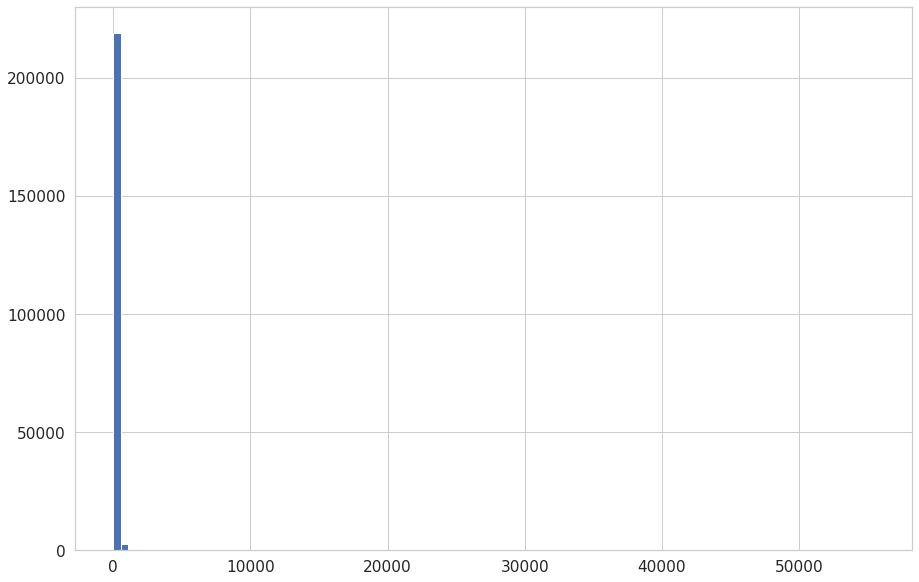

In [45]:
df['len'].hist(bins=100, figsize=(15, 10))

In [46]:
(df['len'] > 2000).sum()

170

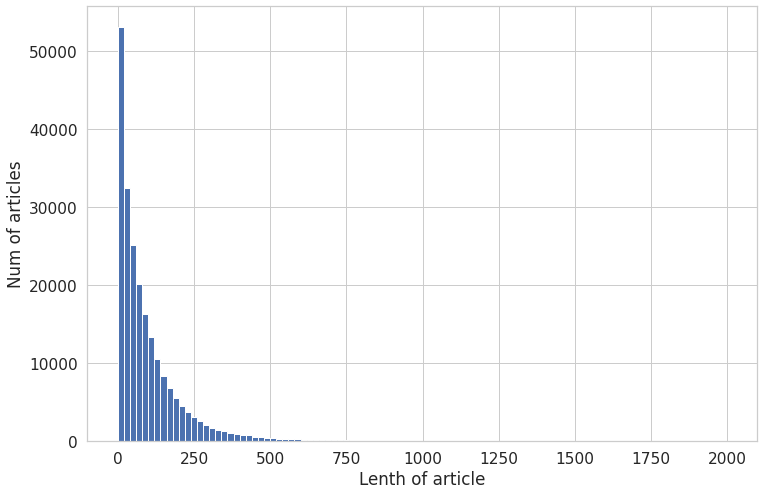

In [47]:
plt.figure(figsize=(12, 8))
plt.hist(df[df['len'] < 2000]['len'], bins=100)
plt.xlabel('Lenth of article')
plt.ylabel('Num of articles');

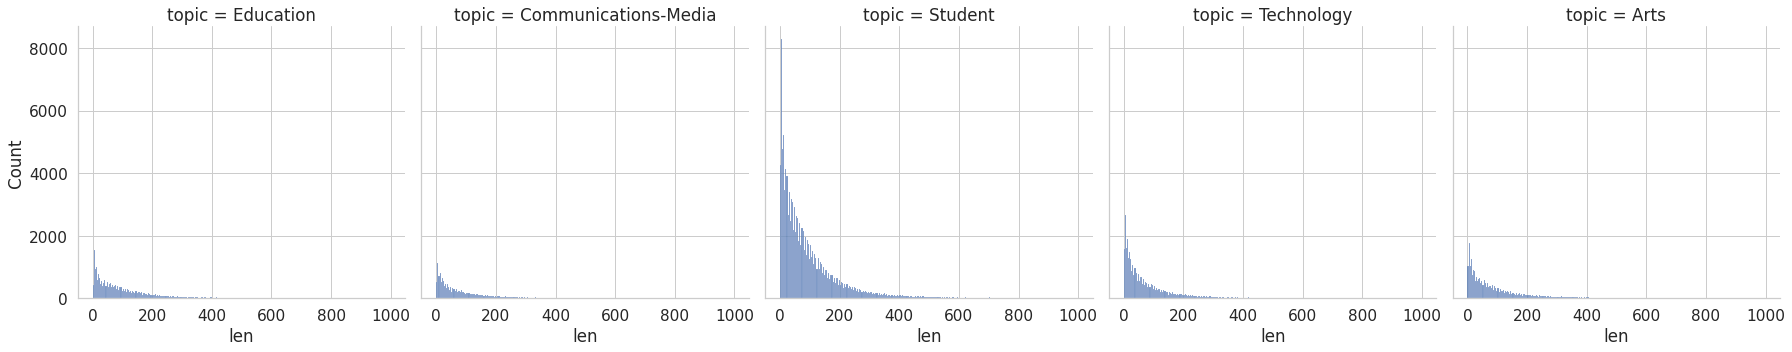

In [66]:
sns.displot(df[df['len'] < 1000], x="len", col="topic", kind='hist')

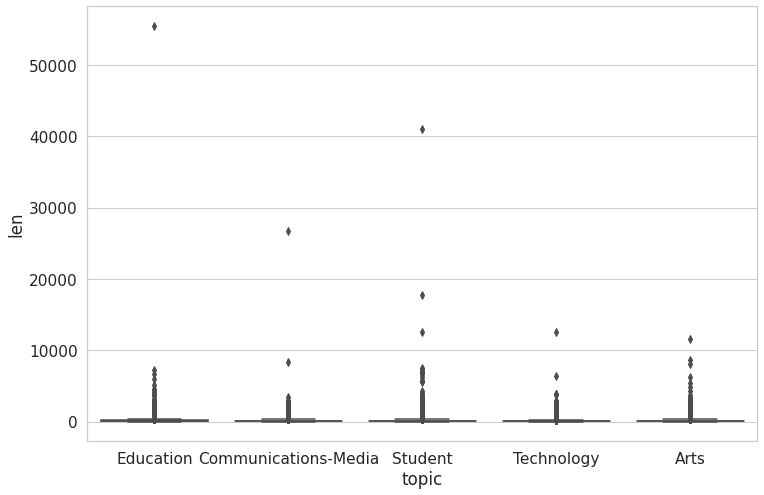

In [57]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="topic", y="len", data=df);

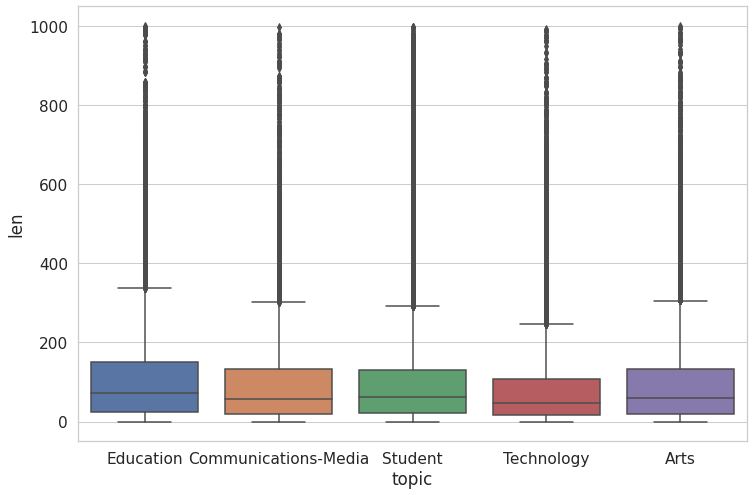

In [58]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="topic", y="len", data=df[df['len'] < 1000]);

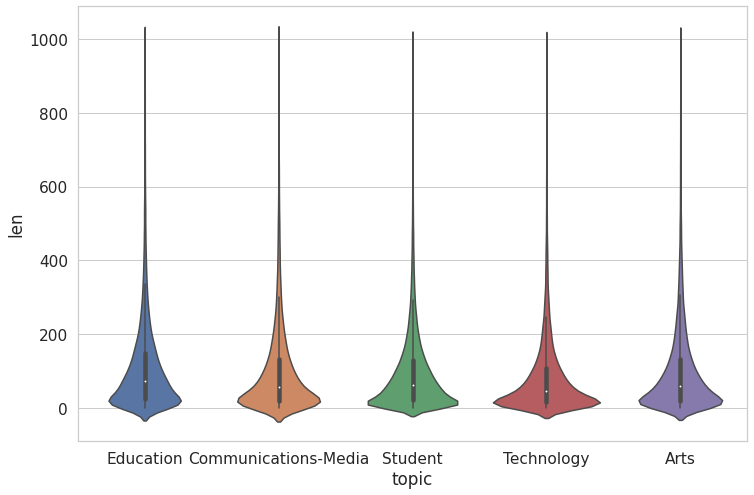

In [61]:
plt.figure(figsize=(12, 8))
sns.violinplot(x="topic", y="len", data=df[df['len'] < 1000]);

Видим что длины статей очень сильно отличаются. С одной стороны много маленьких статей, в которых недостаточно смысла, чтобы понять, на какую тему пишет автор. С другой стороны большая часть текстов очень длинные, чтобы без урезания быть поданными модели, а при урезании может потеряться смысл, характерный для текстов на одну тематику. Кроме того средняя длина текстов очень близка, поэтому ее можно

In [49]:
class Vocabulary:

    def __init__(self, vocab=None):
        self.vocab = vocab

    def encode(self, data):
        if isinstance(data, list) and len(data) > 0 and not isinstance(data[0], str):
            return [self.encode(text) for text in data]
        # data --- это отдельный текст
        indexes = [self.vocab.get(token, self.vocab['unk']) for token in data]
        return indexes

In [ ]:
import gensim.downloader as api
glove_model = api.load("glove-twitter-50")

[==================================================] 100.0% 199.5/199.5MB downloaded


In [ ]:
glove_word2idx = {word: idx for idx, word in enumerate(glove_model.index2word)}

glove_vocab = Vocabulary()
glove_vocab.vocab = glove_word2idx
# dataset.vocab = glove_vocab

In [ ]:
train_dataset.tokenised = glove_vocab.encode(train_dataset.tokenised)
test_dataset.tokenised = glove_vocab.encode(test_dataset.tokenised)

In [ ]:
train_dataset.cut_to_fixed_size(512)
test_dataset.cut_to_fixed_size(512)

In [ ]:
train_dataset.drop_too_short()
test_dataset.drop_too_short()

In [ ]:
len(test_dataset.labels), len(test_dataset.tokenised)

(54941, 54941)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def pad_tensor(vec, length, dim, pad_symbol):
    pad_size = list(vec.shape)
    pad_size[dim] = length - vec.shape[dim]
    answer = torch.cat([vec, torch.ones(*pad_size, dtype=vec.dtype) * pad_symbol], axis=dim)
    return answer

def pad_tensors(tensors, dim=0, pad=0):
    # дополняет тензоры из tensors до общей максимальной длины символом pad
    if isinstance(tensors[0], (int, np.integer)):
        # массив целых чисел
        return torch.LongTensor(tensors)
    elif isinstance(tensors[0], (float, np.float)):
        # массив действительных чисел
        return torch.Tensor(tensors)
    if not isinstance(tensors[0], torch.Tensor):
        # приводим к массивам, чтобы можно было определить тип
        tensors = [np.array(tensor) for tensor in tensors]
        if np.issubdtype(tensors[0].dtype, np.integer):
            tensors = [torch.LongTensor(tensor) for tensor in tensors]
        else:
            tensors = [torch.Tensor(tensor) for tensor in tensors]
    L = max(tensor.shape[0] for tensor in tensors)
    tensors = [pad_tensor(tensor, L, dim=dim, pad_symbol=pad) for tensor in tensors]
    return torch.stack(tensors, dim=0)


class BatchDataLoader(DataLoader):

    def __init__(self, data, batch_size: int=32, pad=0, device="cpu", sort_field="input"):
        self.data = data
        self.batch_size = batch_size
        self.pad = pad
        self.device = device
        self.sort_field = sort_field

    def __iter__(self):
        self.order = np.argsort([len(elem[self.sort_field]) for elem in self.data])[::-1]
        self.idx = 0
        return self

    def __len__(self):
        return (len(self.data)-1) // self.batch_size + 1

    def __next__(self):
        if self.idx >= len(self.data):
            raise StopIteration()
        end = min(self.idx + self.batch_size, len(self.data))
        indexes = self.order[self.idx:end]
        # print(self.idx, end, indexes)
        answer = dict()
        for field in self.data[indexes[0]]:
            # записываем тензоры для всех полей
            answer[field] = pad_tensors([self.data[i][field] for i in indexes]).to(self.device)
        # записываем индексы всех объектов
        answer["indexes"] = indexes
        self.idx = end
        return answer

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x)
        state = states[0]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)
        state = self.dropout(state)
        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

In [ ]:
def measure_quality(y_test, y_pred, average='weighted'):
    accuracy = accuracy_score(y_test, y_pred)
    print('\t average')
    print("accuracy: {:.2f}".format(accuracy))
    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average=average)
    print("precision: {:.2f}".format(precision))
    print("recall: {:.2f}".format(recall))
    print("F1-score: {:.2f}".format(f_score))
    print()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "F1": f_score}

In [ ]:
from tqdm.notebook import tqdm, trange

def training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm=2, num_freeze_iter=1000):
    history = {
        'train_loss':[],
        'val_loss':[],
    }

    unfreeze_flg = False
    freeze_embeddings(model)
    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        
        train_loss = 0

        pbar = tqdm(loaders["train"], leave=False)
        for batch in pbar:

            if not unfreeze_flg and num_iter > num_freeze_iter:
                freeze_embeddings(model, True)
                unfreeze_flg = True
                
            optimizer.zero_grad()

            input_embeds = batch["input"].to(device)
            labels = batch["label"].to(device)

            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            train_loss += loss

            if num_iter % 1000 == 0:
                print('train loss: ', loss.item())
                print('train: ', (prediction.argmax(-1) == labels).float().sum().item())

            loss.backward()

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        
        history['train_loss'].append(train_loss / num_iter)

        valid_loss = 0
        val_labels = None
        val_predictions = None
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for batch in loaders["test"]:
                input_embeds = batch["input"].to(device)
                labels = batch["label"].to(device)
                prediction = model(input_embeds)
            
                valid_loss += criterion(prediction, labels)
                
                if val_labels is None:
                    val_labels = labels
                else:
                    val_labels = torch.hstack([val_labels, labels])
                
                if val_predictions is None:
                    val_predictions = prediction.argmax(-1)
                else:
                    val_predictions = torch.hstack([val_predictions, prediction.argmax(-1)])

                num_objs += len(labels)
                num_iter += 1

            print('valid: ', (prediction.argmax(-1) == labels).float().sum().item())

            val_labels = val_labels.cpu().numpy()
            val_predictions = val_predictions.cpu().numpy()

        history['val_loss'].append(valid_loss / num_iter)

        measure_quality(val_labels, val_predictions, 'weighted')
        measure_quality(val_labels, val_predictions, 'macro')
        measure_quality(val_labels, val_predictions, 'micro')
        
        print(f"\n\tValid Loss: {valid_loss / num_iter}\n\t")

    return history

In [6]:
# import torch
# del loaders, model
# torch.cuda.empty_cache()
# import gc
# gc.collect()

In [ ]:
label2idx

{'Arts': 3,
 'Communications-Media': 2,
 'Education': 1,
 'Student': 0,
 'Technology': 4}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(1 / frequencies).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
max_grad_norm = 1.0

In [ ]:
with torch.no_grad():
    for word, idx in glove_vocab.vocab.items():
        if word in glove_model:
            model.embedding.weight[idx] = torch.from_numpy(glove_model.get_vector(word))

In [ ]:
loaders = {'train': BatchDataLoader(train_dataset, device="cuda:0", batch_size=30),
           'test': BatchDataLoader(test_dataset, device="cuda:0", batch_size=30)}

In [ ]:
history = training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm)

train loss:  1.6110774278640747
train:  3.0
train loss:  1.6200422048568726
train:  5.0
train loss:  1.4596748352050781
train:  14.0
train loss:  1.2138456106185913
train:  13.0
train loss:  1.570433259010315
train:  15.0
train loss:  1.2579361200332642
train:  14.0
train loss:  1.4924745559692383
train:  12.0
train loss:  1.4439321756362915
train:  9.0
valid:  3.0
	 average
accuracy: 0.28
precision: 0.67
recall: 0.28
F1-score: 0.26

	 average
accuracy: 0.28
precision: 0.54
recall: 0.26
F1-score: 0.16

	 average
accuracy: 0.28
precision: 0.28
recall: 0.28
F1-score: 0.28


	Valid Loss: 1.4790983200073242
	


train loss:  2.030658006668091
train:  6.0
train loss:  1.3820970058441162
train:  11.0
train loss:  1.2298492193222046
train:  16.0
train loss:  0.9315871596336365
train:  21.0
train loss:  1.2863380908966064
train:  18.0
train loss:  0.8291810154914856
train:  20.0
train loss:  1.478924036026001
train:  11.0
train loss:  1.2887099981307983
train:  8.0
valid:  4.0
	 average
accuracy: 0.41
precision: 0.68
recall: 0.41
F1-score: 0.41

	 average
accuracy: 0.41
precision: 0.56
recall: 0.33
F1-score: 0.28

	 average
accuracy: 0.41
precision: 0.41
recall: 0.41
F1-score: 0.41


	Valid Loss: 1.3954896926879883
	


train loss:  1.9346290826797485
train:  11.0
train loss:  1.2527590990066528
train:  13.0
train loss:  1.2160249948501587
train:  18.0
train loss:  0.6522600650787354
train:  22.0
train loss:  1.1851508617401123
train:  20.0
train loss:  0.5748424530029297
train:  22.0
train loss:  1.3055006265640259
train:  14.0
train loss:  1.156427264213562
train:  11.0
valid:  4.0
	 average
accuracy: 0.45
precision: 0.65
recall: 0.45
F1-score: 0.46

	 average
accuracy: 0.45
precision: 0.53
recall: 0.37
F1-score: 0.33

	 average
accuracy: 0.45
precision: 0.45
recall: 0.45
F1-score: 0.45


	Valid Loss: 1.3548228740692139
	


train loss:  1.7979332208633423
train:  13.0
train loss:  0.9895987510681152
train:  19.0
train loss:  0.9145717024803162
train:  22.0
train loss:  0.3970787525177002
train:  25.0
train loss:  0.9759137034416199
train:  20.0
train loss:  0.46551769971847534
train:  23.0
train loss:  1.1807752847671509
train:  17.0
train loss:  1.185002326965332
train:  13.0
valid:  4.0
	 average
accuracy: 0.48
precision: 0.63
recall: 0.48
F1-score: 0.49

	 average
accuracy: 0.48
precision: 0.50
recall: 0.39
F1-score: 0.36

	 average
accuracy: 0.48
precision: 0.48
recall: 0.48
F1-score: 0.48


	Valid Loss: 1.3850340843200684
	


train loss:  1.5015907287597656
train:  15.0
train loss:  0.7387824058532715
train:  20.0
train loss:  0.7878413796424866
train:  23.0
train loss:  0.20055197179317474
train:  26.0
train loss:  1.0111099481582642
train:  22.0
train loss:  0.3223108947277069
train:  25.0
train loss:  1.0093570947647095
train:  20.0
train loss:  1.1326922178268433
train:  15.0
valid:  4.0
	 average
accuracy: 0.48
precision: 0.62
recall: 0.48
F1-score: 0.50

	 average
accuracy: 0.48
precision: 0.48
recall: 0.40
F1-score: 0.38

	 average
accuracy: 0.48
precision: 0.48
recall: 0.48
F1-score: 0.48


	Valid Loss: 1.4369933605194092
	


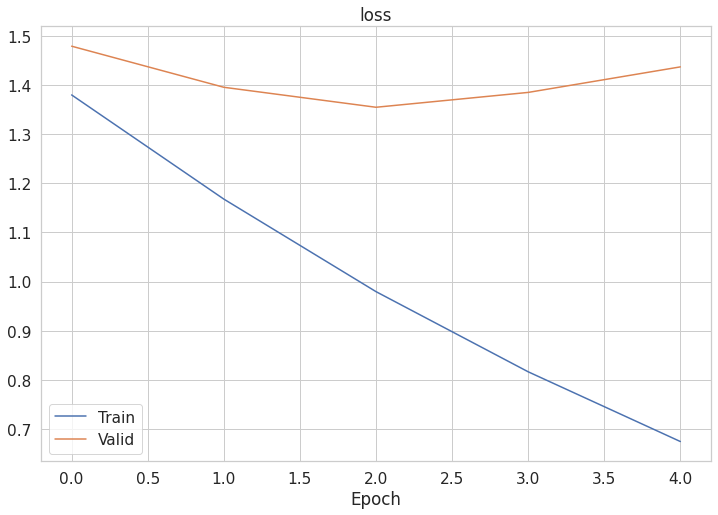

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x) #[:, -1, :]
        state = states[-1]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

    def train_on_batch(self, x, y):
        self.train()
        self.optimizer.zero_grad()
        loss = self._validate(x, y)
        loss["loss"].backward()
        self.optimizer.step()
        return loss

    def validate_on_batch(self, x, y):
        self.eval()
        with torch.no_grad():
            return self._validate(x, y)

    def _validate(self, x, y):
        if self.device is not None:
            y = y.to(self.device)
            x = x.to(self.device)
        prediction = self(x) #   self.forward(x) = self.__call__(x)
        loss = self.criterion(prediction, y)
        labels = prediction.argmax(-1)
        return {"loss": loss, "label": labels}

In [ ]:
def update_metrics(metrics, batch_output, batch_labels):
    n_batches = metrics["n_batches"]
    # Что здесь не так?
    metrics["loss"] = (metrics["loss"] * n_batches + batch_output["loss"].item()) / (n_batches + 1)
    metrics["n_batches"] += 1
    are_equal = (batch_output["label"] == batch_labels).cpu().numpy().astype("int")
    metrics["correct"] += are_equal.sum()
    metrics["total"] += are_equal.shape[0]
    metrics["accuracy"] = metrics["correct"] / max(metrics["total"], 1)

In [ ]:
def do_epoch(model, dataloader, mode="validate", epoch=1):
    metrics = {"correct": 0, "total": 0, "loss": 0.0, "n_batches": 1}

    func = model.train_on_batch if mode == "train" else model.validate_on_batch
    progress_bar = tqdm(dataloader, leave=True)
    progress_bar.set_description(f"{mode}, epoch={epoch}")

    for batch in progress_bar:
        batch_output = func(batch['input'], batch["label"])
        update_metrics(metrics, batch_output, batch["label"])
        progress_bar.set_postfix({"loss": round(metrics["loss"], 4), "acc": round(100 * metrics["accuracy"], 2)})
    return metrics

In [ ]:
train_dataloader = BatchDataLoader(train_dataset, device="cuda", batch_size=30)
test_dataloader = BatchDataLoader(test_dataset, device="cuda", batch_size=30)
NEPOCHS = 5

model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)

best_val_acc = 0.0
checkpoint = "checkpoint_best.pt"

for epoch in range(NEPOCHS):
    do_epoch(model, train_dataloader, mode="train", epoch=epoch+1)
    epoch_metrics = do_epoch(model, test_dataloader, mode="validate", epoch=epoch+1)

    if epoch_metrics["accuracy"] > best_val_acc:
        best_val_acc = epoch_metrics["accuracy"]
        print(f"Saving checkpoint after epoch {epoch+1}")
        torch.save(model.state_dict(), checkpoint)

model.load_state_dict(torch.load(checkpoint))
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")


Saving checkpoint after epoch 1


{'accuracy': 0.31128207723844714,
 'correct': 6150,
 'loss': 1.573903871666301,
 'n_batches': 660,
 'total': 19757}

In [ ]:
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")

Осталось:
1.   Разумные метрики вроде f1
2.   Сделать, чтобы училось, сейчас не учится
3.   С 0/1/2 полносвязными слоями, fastext и bert embendings



In [ ]:
torch.argmax(torch.Tensor([[1, 2], [5, 4]]), axis=1)

tensor([1, 0])